Steps I follow:

1. Create an AR(2) time series.
2. Calculate information storage based on my method
3. Calculate information storage based on ChatGPT's method
4. Compare the results!

Full disclosure - I wrote the code first by myself and asked ChatGPT to refine it.

# Sample time series generation

An AR(2) series is generated.

In [ ]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt

# Step 1. Create a time series: AR(2)
def generate_time_series(phi1: float,
                         phi2: float,
                         sigma: float,
                         n: int,
                         seed: int=42) -> np.ndarray:
    """
    Generates a synthetic AR(2) time series.

    Parameters:
    phi1 (float): AR coefficient for lag 1.
    phi2 (float): AR coefficient for lag 2.
    sigma (float): Standard deviation of noise.
    n (int): Length of the time series.
    seed (int): Random seed for reproducibility.

    Returns:
    np.ndarray: The generated time series.
    """
    np.random.seed(seed)
    epsilon = np.random.normal(0, sigma, n) # noise
    ts = np.zeros(n)  # Preallocate the time series array
    for t in range(2, n):
      ts[t] = phi1 * ts[t-1] + phi2 * ts[t-2] + epsilon[t]
    return ts

# AR(2) parameters
PHI1 = 0.4
PHI2 = -0.3
SIGMA = 1   # Standard deviation of the white noise
N_TS = 100  # Length of the time series

my_tseries = generate_time_series(PHI1, PHI2, SIGMA, N_TS)

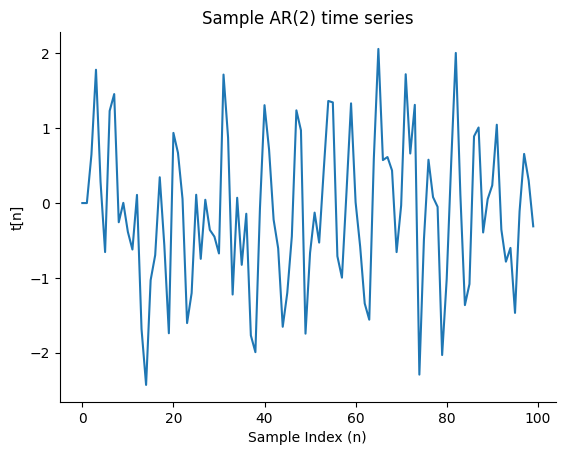

In [ ]:
# @title
fig, ax = plt.subplots()
ax.plot(my_tseries)
ax.set_xlabel('Sample Index (n)')
ax.set_ylabel('t[n]')
ax.set_title('Sample AR(2) time series')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()


# Kernel function: Heaviside function

`my_heaviside` implements the Heaviside function (𝚯) with radius `r`.

$$
𝚯(x) = \begin{cases}
  1, & x \le r\\    
  0, & x \gt r    
\end{cases}
$$

In [ ]:
# Step 2-1. Heaviside kernel with radius 'r'
def my_heaviside(x: float, r: float) -> int:
  """
  Heaviside step function for threshold comparison.

  Parameters:
  x (float): Input value.
  r (float): Threshold value.

  Returns:
  int: 1 if x <= r, else 0.
  """
  return 1 if x <= r else 0

# Kernel Density Estimation
The next step was to write a function that calculates the kernel density estimate. I had to modify it multiple times working with ChatGPT. That's a typical learning process... but it took me a LOT of time.

`prob` can calculate $p(x_n)$, the probability of a single value $x_n$ or $p(x_n^m)$, that of a vector. Furthermore, it can calculate $p(x_n, x_n^m)$, the joint probability.

In [ ]:
# Step 2-2. Kernel density estimate
def prob(series: list | np.ndarray,
         x_n: int | float | np.ndarray | list,
         r: float,
         joint: bool = False) -> float:
  """
  computes the probability for a given value or vector
  in the series.

  Parameters:
  series (list or np.ndarray): The input time series.
  x_n (int, float, np.ndarray or list): The value or vector
      for probability calculation.
  r (float): Radius for the Heaviside kernel.
  joint (bool): Whether to compute joint probability.

  Returns:
  float: The calculated probability.
  """
  if isinstance(x_n, (int, float)) and joint:
    raise ValueError("Set 'joint=False' for a scalar x_n")

  series_len = len(series)
  p = 1 if isinstance(x_n, (int, float)) else len(x_n)

  if p > 1:
    iterend = series_len-p+1 if joint else series_len-p
    sumcount = sum(
        my_heaviside(
            max(abs(xn-xi) for xn, xi in zip(x_n, series[k:k+p])),
            r
        )
        for k in range(iterend)
    )
    return sumcount/iterend
  sumcount = sum(my_heaviside(abs(x_n-x_i), r) for x_i in series) / series_len
  return sumcount

So `prob` starts with checking if `x_n` is a scalar (`int` or `float`) and `joint=True`. For a scalar you CANNOT calculate joint probaility.

Depending on the value of `p`, the length of `x_n`, the return of the function is different.

## **_p_ = 1**

The last two lines correspond to `p = 1`,
$p(x_n) = \frac{1}{N}\sum_{i=1}^N K(||x_n - x_i||)$. Here, $N$ is the length of a time series.

## **_p_ > 1**

If `p > 1`, the subscript $i$ has different ranges depending on which probability is calculated.

### $p(x_n^m)$ (a.k.a. `joint=False`)

If $p(x_n^m)$ is calculated, $x_n^m$ cannot include the very last element of `series`. Remember, $x_n^m = (x_{n-1}, ..., x_{n-m})$.


Let's use a simple example to understand. Suppose $x = (0,1,2,3,4,5,6)$ and $m = 2$. How do we calculate $p(x_n^m)$ for $n=3$?

First, $x_3^2 = (x_{3-1}, x_{3-2}) = (1,0)$. Then we need to find $x_i^m$ to calculate $p(x_n^m)$.

Xiong et al. (2017) does not have an equation for it, but we can tweak eq.(14). Realizations of $x_i^m$ will be $(1, 0), (2,1), (3,2), (4,3), (5,4)$ for $i = 3, 4, 5, 6, 7$. Note that $(6,5)$ is not a possible value because this is $x_8^2$. However, there is no $x_8$, so $x_8^2$ is impossible.

Each of these Chebyshev differences will be the input to the kernel function:

1.   $max(|1-1|, |0-0|) = 0$
2.   $max(|1-2|, |0-1|) = 1$
3.   $max(|1-3|, |0-2|) = 2$
4.   $max(|1-4|, |0-3|) = 3$
5.   $max(|1-5|, |0-4|) = 4$

Let's set $r$, the Heaviside function's threshold, as 1.5. Then $K(.)$ will be $(1, 1, 0, 0, 0)$. Check eq.(18) of the article to understand why this is. Then $p(x_3^2) =\frac{1}{5}\sum_{i=3}^7 K(||x_n^m - x_i^m||) = \frac{2}{5}$.

The denominator of $p(x_3^2)$ is 5 (=7-2) and is equal to `series_len - p`.

### $p(x_n, x_n^m)$ (a.k.a. `joint=True`)

If $p(x_n, x_n^m)$ is calculated (`joint=True`), $(x_n, x_n^m) = (x_n, x_{n-1},...,x_{n-m})$ is a m+1 vector. In our example, $(x_3, x_3^2) = (2,1,0)$. Five corresponding $(x_i, x_i^m)$ values will be $(2,1,0), (3,2,1), (4,3,2), (5,4,3), (6,5,4)$.

$p(x_3, x_3^2) = \frac{1}{5}\sum_{i=3}^7 K(||(x_n, x_n^m) - (x_i, x_i^m)||) = (1+1+0+0+0)/5.$ The denominator is again 5. This is NOT `series_len - p` which is 7 - 3 = 4. In fact, it is `series_len - p + 1`.

Consequently, to handle both cases in one function, the denominator (`iterend`) is set conditionally. It is `series_len - p + 1` for `joint=True` and `series_len - p` for `joint=False`.

I admit that this is somewhat _erroneous_, because $p(x_n^m)$ is also a **joint** probability distribution: $p(x_{n-1},...,x_{n-m})$. It works though.

# Information Storage: my implementation

In [ ]:
# Step 2-3. Integrate everything to calculate the kernel density estimate
def my_information_storage(series: list | np.ndarray,
                           m: int,
                           r: float) -> float:
  """
  Computes the information storage of a time series.

  Parameters:
  series (list or np.ndarray): The input time series.
  m (int): Embedding dimension.
  r (float): Radius for Heaviside kernel.

  Returns:
  float: The computed information storage value.
  """
  series_length = len(series)
  numerator = sum(
      prob(series, series[n-m:n+1], r, joint=True)
      for n in range(m, series_length)
      ) / (series_length - m)
  denominator = sum(
      prob(series, series[n-m:n], r) * prob(series, series[n], r)
      for n in range(m, series_length)
      ) / (series_length-m)
  return np.log(numerator/denominator)

`numerator` is $\langle p(x_n, x_n^m) \rangle$ and `denominator` is $\langle p(x_n)*p(x_n^m) \rangle$.

In [ ]:
# Step 2-4. Run my implementation
# Let's try for m = 2, r = 0.2 * std(series)
embedding_dim = 2
radius = 0.2*np.std(my_tseries)
S_X = my_information_storage(my_tseries, embedding_dim, radius)
print(f"My Information Storage: {S_X:.4f}")

My Information Storage: 1.5866


# ChatGPT's work
Here I provide ChatGPT's version. This also went though many edits. My lesson was that answers of ChatGPT should be validated, ALL THE TIME.

In [ ]:
# Step 3-1. ChatGPT's prep functions

def heaviside_kernel(distance, r):
  """Heaviside kernel function."""
  return 1 if distance <= r else 0

def chebyshev_distance(x, y):
  """Compute Chebyshev distance."""
  return np.max(np.abs(x-y))


def information_storage_gpt(x_series, m, r):
  N = len(x_series)
  if N <= m:
    raise ValueError("The length of the time series must be\
    greater than the embedding dimension m.")

  # Calculate marginal densities
  p_x = calculate_kernel_density(x_series, r)

  # Construct embedding vectors for p(x_n^m)
  x_embedded = np.array([x_series[i-m:i+1][::-1] for i in range(m, N)])

  # Calculate joint densities
  p_joint = calculate_joint_density(x_series, m, r)

  # Calculate p(x_n^m)
  p_x_m = calculate_kernel_density(x_embedded, r)

  # Compute Information Storage
  S_X = 0
  for n in range(m, N):
    # previously it was `p_joint[n-m] > 0`
    if p_joint > 0 and p_x[n] > 0 and p_x_m[n-m] > 0:
      S_X += np.log(p_joint / (p_x[n]*p_x_m[n-m]))
  S_X /= (N-m)

  return S_X

ChatGPT prepares two separate functions: `calculate_kernel_density` and `calculate_joint_density`. The former is equal to my `prob` with a scalar `x_n`. The latter is the same as my `prob` with a vector `x_n` & `joint=True`.

In [ ]:
# Step 3-2. ChatGPT's density estimation, part I
def calculate_kernel_density(x_series, r, m=None):
  """
  Estimate the probability density p(x_n) or p(x_n^m)
  using kernel density estimation.

  Parameters:
  x_series (ndarray): Time series data (length N).
  r (float): Radius for the Heaviside kernel.
  m (int, optional): Embedding dimension (number of lags).
                     If None, calculates for p(x_n).

  Returns:
  ndarray: Probability densities for each x_n or x_n^m.
  """
  N = len(x_series)
  start_index = m if m else 0
  p = np.zeros(N - start_index)
  for n in range(start_index, N):
    for i in range(N):
      distance = chebyshev_distance(x_series[n], x_series[i])
      p[n - start_index] += heaviside_kernel(distance, r)
    p[n - start_index] /= N
  return p

def calculate_joint_density(x_series, m, r):
  """
  Estimate the joint probability density <p(x_n, x_n^m)>
  using kernel density estimation.

  Parameters:
    x_series (ndarray): Time series data (length N)
    m (int): Embedding dimension (number of lags)
    r (float): Radius for the Heaviside kernel

  Returns:
    float: The expected joint density <p(x_n, x_n^m)>
  """
  N = len(x_series)
  if N <= m:
    raise ValueError("Time series length must be greater\
     than the embedding dimension.")

  # Create all lagged vectors [x_i, x_i^m]; Shape: (N-m, m+1)
  lagged_vectors = np.array([x_series[i-m:i+1][::-1] for i in range(m, N)])

  # Joint density estimation
  joint_density_sum = 0
  for x_target in lagged_vectors:
    density = 0
    for x_candidate in lagged_vectors:
      distance = chebyshev_distance(x_target, x_candidate)
      density += heaviside_kernel(distance, r)
    # Normalize inner loop
    joint_density_sum += density / len(lagged_vectors)

  # Normalize outer loop
  return joint_density_sum / len(lagged_vectors)

ChatGPT also prepares another function, `calculate_expected_product`. This was done after so many frustrating attempts of mine...

In [ ]:
# Step 3-3. ChatGPT's density estimation, part II
def calculate_expected_product(x_series, m, r):
  """
  Calculate <p(x_n) * p(x_n^m)>.

  Parameters:
  x_series (ndarray): Time series data (length N).
  m (int): Embedding dimension (number of lags).
  r (float): Radius for the Heaviside kernel.

  Returns:
  float: The expected value <p(x_n)*p(x_n^m)>,
         calculated over all valid n in the time series
  """
  N = len(x_series)
  if N <= m:
    raise ValueError("Time series length must be greater\
     than the embedding dimension.")

  # Calculate p(x_n)
  p_x = calculate_kernel_density(x_series, r, m=0)

  # Create lagged vectors for p(x_n^m); Shape: (N-m, m)
  lagged_vectors = np.array([x_series[i-m:i][::-1] for i in range(m, N)])
  p_x_m = np.zeros(N-m) # Preallocate memory
  for n, x_target in enumerate(lagged_vectors):
    for x_candidate in lagged_vectors:
      distance = chebyshev_distance(x_target, x_candidate)
      p_x_m[n] += heaviside_kernel(distance, r)
    p_x_m[n] /= len(lagged_vectors)

  # Calculate the expected product
  expected_product = 0
  for n in range(N-m):
    expected_product += p_x[n+m] * p_x_m[n]

  return expected_product / (N-m)

In [ ]:
# Step 3-4. Everything integrated
def gpt_information_storage(x_series, m, r):
  N = len(x_series)
  if N <= m:
    raise ValueError("The length of the time series must be greater\
     than the embedding dimension m.")

  # Calculate joint densities
  p_joint = calculate_joint_density(x_series, m, r)

  # Calculate <p(x_n) * p(x_n^m)>
  expected_product = calculate_expected_product(x_series, m, r)

  # Compute Information Storage
  S_X = np.log(p_joint / expected_product)

  return S_X

In [ ]:
# Step 3-5. Run ChatGPT implementation

# Same configuration
gpt_S_X = gpt_information_storage(my_tseries, embedding_dim, radius)
print(f"GPT's Information Storage: {gpt_S_X:.4f}")

GPT's Information Storage: 1.5866


# Conclusion
Both return $S(X)$ = 1.5866.

I initially started with Python's basic features. ChatGPT mostly handles data using NumPy's ndarray.

In terms of structure, I handled everything in one function, `prob`. ChatGPT provides a modular fashion. `calculate_kernel_density` is used in `calculate_expected_product`. There is a separate `calculate_joint_density`. Next time I can mimic this behavior for better management.

Finally, ChatGPT's method is more _correct_ in how it prepares $x_n^m = (x_{n-1},...,x_{n-m})$. In different functions, `lagged_vectors` is prepared, and the segments of the original time series are 'flipped' by the command: `[::-1]`. I have not done this, and in terms of calculation it does not matter.